In [7]:
!tar zxf aclImdb_v1.tar.gz
!rm -rf aclImdb/train/unsup
!cat aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [14]:
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [15]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--- Loading the IMDB dataset ---
Number of training data: 25000
Number of testing data: 25000
Labels (['neg', 'pos']): 0=Negative, 1=Positive
Example of training data x_train[0]:
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mu...

--- [Problem 1] Scratch Implementation of BoW (1-gram to 1-gram) ---
      this  movie  is  soooo  funny  what  a  i  never  best  ever
Doc0     1      1   1      1      1     0  0  0      0     0     0
Doc1     0      1   0      0      0     1  1  1      1     0     0
Doc2     1      2   0      0      0     0  0  0      0     1     1

--- [Problem 1] Scratch Implementation of BoW (2-gram to 2-gram) ---
      this movie  movie is  is soooo  soooo funny  what a  a movie  movie i  \
Doc0           1         1    

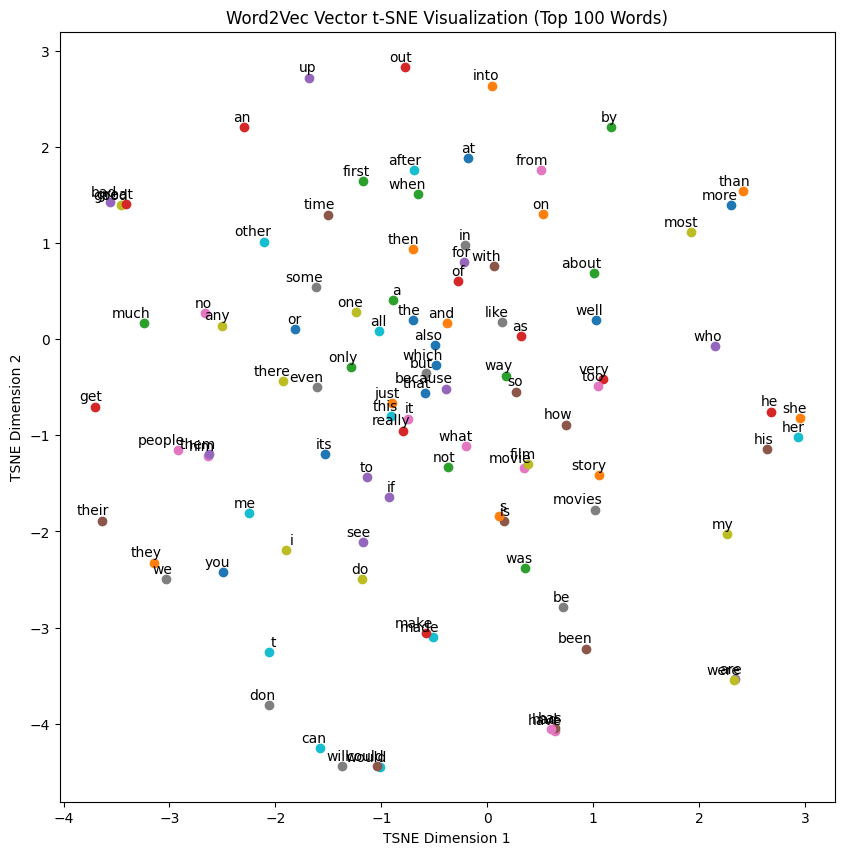


--- [Problem 8] Sentiment Classification using Word2Vec ---
Word2Vec sentence vectorization complete. Training data dimension: (25000, 100)
Word2Vec + Logistic Regression test accuracy: 0.8528


In [16]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Import necessary libraries
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Global flag to check for Word2Vec availability
W2V_AVAILABLE = False
try:
    import nltk
    # Downloading NLTK stopwords might be necessary on the first run depending on the environment
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    from gensim.models import Word2Vec
    W2V_AVAILABLE = True
    ENGLISH_STOP_WORDS = stopwords.words('english')
except ImportError as e:
    print(f"Warning: {e}. NLTK or Gensim might not be installed. Word2Vec related problems will be skipped.")
    ENGLISH_STOP_WORDS = []


# --- 1. Loading the IMDB dataset ---

def load_imdb_data(data_path='./aclImdb/'):
    """Function to load the IMDB dataset"""
    print("--- Loading the IMDB dataset ---")
    try:
        train_review = load_files(data_path + 'train/', encoding='utf-8')
        x_train, y_train = train_review.data, train_review.target

        test_review = load_files(data_path + 'test/', encoding='utf-8')
        x_test, y_test = test_review.data, test_review.target

        print(f"Number of training data: {len(x_train)}")
        print(f"Number of testing data: {len(x_test)}")
        print(f"Labels ({train_review.target_names}): 0=Negative, 1=Positive")
        print(f"Example of training data x_train[0]:\n{x_train[0][:300]}...")
        return x_train, y_train, x_test, y_test
    except FileNotFoundError:
        print("\n**Error:** Dataset directory not found.")
        print("Please check if the data has been downloaded and extracted to `./aclImdb/` using `!wget` and `!tar` commands.")
        return None, None, None, None


# --- 2. [Problem 1] Scratch Implementation of BoW (1-gram and 2-gram) ---

def scratch_bow(sentences, ngram_range=(1, 1)):
    """
    Calculates 1-gram or n-gram BoW for a given list of sentences.
    Implementation without using scikit-learn.
    """
    print(f"\n--- [Problem 1] Scratch Implementation of BoW ({ngram_range[0]}-gram to {ngram_range[1]}-gram) ---")

    # 1. Preprocessing and Tokenization: Lowercasing, removing non-word characters, creating word lists
    token_lists = []
    for sent in sentences:
        # Lowercase and replace punctuation with spaces
        sent = sent.lower()
        # Replace non-alphanumeric characters (like !?. etc.) with spaces before splitting into words
        tokens = re.findall(r'\b\w+\b', sent)
        token_lists.append(tokens)

    # 2. Building vocabulary and counting n-grams
    vocabulary = defaultdict(lambda: len(vocabulary))
    bow_vectors = []

    for tokens in token_lists:
        # Count dictionary
        count_dict = defaultdict(int)

        # Process from 1-gram up to n-gram
        for n in range(ngram_range[0], ngram_range[1] + 1):
            if n > len(tokens):
                continue

            for i in range(len(tokens) - n + 1):
                # Generate n-gram token
                ngram = " ".join(tokens[i:i+n])

                # Add to vocabulary (if not already in vocabulary)
                _ = vocabulary[ngram]

                # Increase count
                count_dict[ngram] += 1

        # 3. Vectorization (holding in a Dictionary for sparse representation)
        bow_vectors.append(count_dict)

    # 4. Formatting for display in DataFrame format

    # Sort vocabulary list by ID (for DataFrame column order)
    sorted_vocab = sorted(vocabulary.items(), key=lambda item: item[1])
    column_names = [item[0] for item in sorted_vocab]

    # Create BoW matrix (vocabulary size x number of samples)
    bow_matrix = np.zeros((len(sentences), len(vocabulary)), dtype=int)
    for i, count_dict in enumerate(bow_vectors):
        for token, count in count_dict.items():
            col_index = vocabulary[token]
            bow_matrix[i, col_index] = count

    df = pd.DataFrame(bow_matrix, columns=column_names, index=[f"Doc{i}" for i in range(len(sentences))])
    print(df)
    return df

# --- 3. [Problem 2] TF-IDF Calculation (scikit-learn) & [Problem 3] Learning using TF-IDF ---

def tfidf_classification(x_train, y_train, x_test, y_test, max_features=5000, ngram_range=(1, 1)):
    """
    Performs TF-IDF vectorization and classification using Logistic Regression.
    """
    print(f"\n--- [Problem 2 & 3] TF-IDF Vectorization and Classification (MaxFeat={max_features}, Ngram={ngram_range}) ---")

    # Use NLTK stopwords
    stop_words = ENGLISH_STOP_WORDS

    # Instantiate TfidfVectorizer
    # Default token_pattern='(?u)\\b\\w\\w+\\b' is used, excluding single-character tokens (e.g., a, I)
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        stop_words=stop_words,
        max_features=max_features
    )

    # Vectorize training data (fit_transform)
    X_train_tfidf = vectorizer.fit_transform(x_train)
    # Vectorize testing data (transform)
    X_test_tfidf = vectorizer.transform(x_test)

    print(f"TF-IDF vectorization complete. Training data dimension: {X_train_tfidf.shape}")

    # Train Logistic Regression model (binary classification)
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Prediction and evaluation
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Logistic Regression test accuracy: {accuracy:.4f}")
    print("\n[Verification Points]")
    print(f"  - Change max_features={max_features} to verify the relationship between dimension and accuracy")
    print(f"  - Change ngram_range={ngram_range} to (1, 2) or (1, 3) to verify the impact of adding word order information on accuracy")

    return X_train_tfidf, X_test_tfidf

# --- 4. [Problem 4] Scratch Implementation of TF-IDF ---

def scratch_tfidf(sentences):
    """
    Calculates standard and scikit-learn style TF-IDF for a given list of sentences.
    """
    print("\n--- [Problem 4] Scratch Implementation of TF-IDF ---")

    # Calculate BoW (reuse function from Problem 1)
    bow_df = scratch_bow(sentences, ngram_range=(1, 1))
    bow_matrix = bow_df.values
    vocab = bow_df.columns.tolist()
    N = len(sentences) # Number of samples

    # 1. TF Calculation (scikit-learn style: n_t,d)
    # Scikit-learn's TF is simply the term frequency (same as BoW)
    tf_sklearn = bow_matrix

    # 2. Standard TF Calculation (n_t,d / sum(n_s,d))
    # Sum of all token occurrences in each sample (denominator)
    sum_tokens_per_doc = bow_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero when denominator is 0
    sum_tokens_per_doc[sum_tokens_per_doc == 0] = 1
    tf_standard = bow_matrix / sum_tokens_per_doc

    # 3. Required for IDF calculation: df(t) (number of samples where token t appears)
    df_t = np.sum(bow_matrix > 0, axis=0)

    # 4. Standard IDF Calculation (log(N / df(t)))
    # Base of the logarithm is arbitrary, natural logarithm (e) is used here
    idf_standard = np.log(N / df_t)

    # 5. Scikit-learn's IDF Calculation (log((1 + N) / (1 + df(t))) + 1)
    idf_sklearn = np.log((1 + N) / (1 + df_t)) + 1

    # 6. TF-IDF Calculation
    tfidf_standard = tf_standard * idf_standard
    tfidf_sklearn = tf_sklearn * idf_sklearn

    # Display results
    print("\n[Standard TF-IDF Results]")
    df_standard = pd.DataFrame(tfidf_standard, columns=vocab, index=[f"Doc{i}" for i in range(N)])
    print(df_standard.round(4))

    print("\n[Scikit-learn style TF-IDF Results (without normalization)]")
    df_sklearn = pd.DataFrame(tfidf_sklearn, columns=vocab, index=[f"Doc{i}" for i in range(N)])
    print(df_sklearn.round(4))


# --- 5. [Problem 5] Corpus Preprocessing (for Word2Vec) ---

def preprocess_for_word2vec(text_list):
    """
    Preprocessing for Word2Vec training: URL removal, special character removal, lowercasing, token splitting.
    """
    print("\n--- [Problem 5] Corpus Preprocessing for Word2Vec ---")
    processed_sentences = []

    for text in text_list:
        # 1. Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # 2. Remove HTML tags (may be present in IMDB data)
        text = re.sub(r'<[^>]+>', '', text)

        # 3. Remove special characters and lowercase (replace non-alphabetic and non-numeric characters with spaces)
        # Punctuation is removed as word distance is important in Word2Vec
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())

        # 4. Split into tokens (consecutive spaces are treated as one)
        tokens = [word for word in text.split() if word]
        processed_sentences.append(tokens)

    print(f"Example of processed sentence (first 5 words): {processed_sentences[0][:5]}...")
    return processed_sentences

# --- 6. [Problem 6] Word2Vec Training & [Problem 7] Similar Words and Visualization ---

def train_and_visualize_word2vec(sentences):
    """
    Trains Word2Vec, searches for similar words, and visualizes (TSNE).
    """
    print("\n--- [Problem 6] Word2Vec Training ---")
    # min_count=5: Ignore words with frequency less than 5
    # vector_size=100: Set the dimension of distributed representation to 100
    # window=5: Maximum distance between the current and predicted word within a sentence
    # workers=4: Use 4 parallel workers
    # sg=1: Use Skip-gram (default is sg=0 for CBoW)
    # NOTE: Word2Vec is guaranteed to be available here due to the check in the main block
    model = Word2Vec(sentences, min_count=5, vector_size=100, window=5, workers=4, sg=1)

    print(f"Number of words in vocabulary: {len(model.wv.index_to_key)}")
    print("Training complete.")

    # [Problem 7] Vector Visualization and Similar Words
    print("\n--- [Problem 7] Preparing for Similar Word Search and Visualization ---")

    # Search for similar words
    try:
        similar_words = model.wv.most_similar(positive=['good'], topn=5)
        print("Top 5 words most similar to 'good':")
        for word, sim in similar_words:
            print(f"  - {word}: {sim:.4f}")

        similar_words_bad = model.wv.most_similar(positive=['bad'], topn=5)
        print("\nTop 5 words most similar to 'bad':")
        for word, sim in similar_words_bad:
            print(f"  - {word}: {sim:.4f}")
    except KeyError as e:
        print(f"Error during similar word search: {e}. This word is not in the vocabulary.")

    # Prepare for visualization (t-SNE)
    words = model.wv.index_to_key[:100] # Select top 100 words
    vectors = model.wv[words]

    print(f"\nRunning TSNE: Compressing vectors of top {len(words)} words to 2 dimensions...")
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42)
    vectors_tsne = tsne_model.fit_transform(vectors)

    # Plot (assuming execution in Colab/Jupyter environment)
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1])
        plt.annotate(word,
                     xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title("Word2Vec Vector t-SNE Visualization (Top 100 Words)")
    plt.xlabel("TSNE Dimension 1")
    plt.ylabel("TSNE Dimension 2")
    plt.show()

    return model

# --- 7. [Problem 8] Movie Review Classification using Word2Vec (Advanced) ---

def w2v_classification(x_train_processed, y_train, x_test_processed, y_test, w2v_model):
    """
    Creates sentence vectors by averaging Word2Vec word vectors and performs classification.
    """
    print("\n--- [Problem 8] Sentiment Classification using Word2Vec ---")

    def document_to_vector(doc_tokens, model, vector_size):
        """Calculates the average of all word vectors in a review to create a sentence vector"""
        vectors = []
        for word in doc_tokens:
            if word in model.wv:
                vectors.append(model.wv[word])

        if vectors:
            # Average of existing word vectors
            return np.mean(vectors, axis=0)
        else:
            # Return a zero vector if the document consists only of words not in the vocabulary
            return np.zeros(vector_size)

    VECTOR_SIZE = w2v_model.wv.vector_size

    # Convert training and testing data to sentence vectors
    X_train_w2v = np.array([document_to_vector(tokens, w2v_model, VECTOR_SIZE) for tokens in x_train_processed])
    X_test_w2v = np.array([document_to_vector(tokens, w2v_model, VECTOR_SIZE) for tokens in x_test_processed])

    print(f"Word2Vec sentence vectorization complete. Training data dimension: {X_train_w2v.shape}")

    # Train Logistic Regression model (binary classification)
    model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
    model.fit(X_train_w2v, y_train)

    # Prediction and evaluation
    y_pred = model.predict(X_test_w2v)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Word2Vec + Logistic Regression test accuracy: {accuracy:.4f}")


# --- Main Execution Block ---

if __name__ == '__main__':
    # 0. Load the IMDB dataset
    x_train, y_train, x_test, y_test = load_imdb_data()

    if x_train is None:
        # Exit on data loading error
        exit()

    # --- 1. Scratch Implementation of Classical Methods ---
    mini_dataset = [
      "This movie is SOOOO funny!!!",
      "What a movie! I never",
      "best movie ever!!!!! this movie"
    ]

    # [Problem 1] Scratch Implementation of BoW
    scratch_bow(mini_dataset, ngram_range=(1, 1))
    scratch_bow(mini_dataset, ngram_range=(2, 2))


    # --- 2. TF-IDF Calculation and Learning (scikit-learn) ---

    # [Problem 2 & 3] TF-IDF Calculation and Classification
    # Execute with max vocabulary size 5000 and 1-gram only
    X_train_tfidf, X_test_tfidf = tfidf_classification(x_train, y_train, x_test, y_test, max_features=5000, ngram_range=(1, 1))


    # --- 3. Scratch Implementation of TF-IDF ---

    # [Problem 4] Scratch Implementation of TF-IDF
    scratch_tfidf(mini_dataset)


    # --- 4. Distributed Representation using Word2Vec ---
    if W2V_AVAILABLE:
        # [Problem 5] Corpus Preprocessing
        x_train_processed = preprocess_for_word2vec(x_train)
        x_test_processed = preprocess_for_word2vec(x_test) # Preprocess test data similarly

        # [Problem 6, 7] Word2Vec Training, Similar Words, Visualization
        w2v_model = train_and_visualize_word2vec(x_train_processed)

        # [Problem 8] Classification using Word2Vec
        w2v_classification(x_train_processed, y_train, x_test_processed, y_test, w2v_model)
    else:
        print("\n--- Skipping Word2Vec steps (Problems 5-8) due to missing 'gensim' library. ---")
